In [1]:
def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('--cuda', type=str2bool, default='true')
    parser.add_argument('--gpuid', type=int, default=3)

    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--vocabulary_size', type=int, default=100000)
    parser.add_argument('--embedding_size', type=int, default=128)

    parser.add_argument('--learning_rate', type=float, default=1.0)
    parser.add_argument('--num_steps', type=int, default=100001)
    parser.add_argument('--avg_step', type=int, default=2000)
    parser.add_argument('--ckpt_step', type=int, default=10000)

    parser.add_argument('--skip_window', type=int, default=1)
    parser.add_argument('--num_skips', type=int, default=2)
    parser.add_argument('--num_sampled', type=int, default=64)

    parser.add_argument('--valid_size', type=int, default=16)
    parser.add_argument('--valid_window', type=int, default=100)
    
    print(parser)
    return parser.parse_args()

In [2]:
import os
import random
import pickle
import zipfile
import argparse
import collections
import numpy as np

import torch
from torch.autograd import Variable

from tempfile import gettempdir
from sklearn.preprocessing import normalize
from six.moves import urllib
from skip_gram import SkipGram

import matplotlib.pyplot as plt
torch.manual_seed(1)

np.set_printoptions(precision=2)
verbose = 0

In [3]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [4]:
def maybe_create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
        print("Created a path: %s" % path)

In [5]:
def maybe_download(file_name, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    url = 'http://mattmahoney.net/dc/'
    local_file_name = os.path.join(gettempdir(), file_name)

    if not os.path.exists(local_file_name):
        local_file_name, _ = urllib.request.urlretrieve(url + file_name, local_file_name)

    stat_info = os.stat(local_file_name)

    if stat_info.st_size == expected_bytes:
        print('Found and verified', file_name)
    else:
        print(stat_info.st_size)
        raise Exception('Failed to verify' + local_file_name + '. Can you get to it with a browser?')

    return local_file_name

In [6]:
def read_data(file_name):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(file_name) as f:
        vocabs = (f.read(f.namelist()[0])).split()
    return vocabs

In [7]:
class FakeArguments:
  '''À utiliser à la place de parse_arguments() quand on n'utilise pas un script .py'''
  def __init__(self, vocabulary_size, avg_step=20, ckpt_step=50, num_steps=100, verbose=0):
    self.avg_step = avg_step # iteration à laquelle on imprime le loss moyen
    self.ckpt_step = ckpt_step # iteration à laquelle on lance un test
    self.num_steps = num_steps # Nombre total d'itérations
    self.cuda = str2bool('false')
    self.gpuid = 3
    self.learning_rate = 1.0    
    self.vocabulary_size = vocabulary_size

    if verbose:
      print('\tTaille du dictionnaire :', self.vocabulary_size)

    print("\n\tCalcule des paramètres de configuration")
    self.vocabulary_size = self.vocabulary_size

    size = int(0.128*100/self.vocabulary_size)
    self.embedding_size = size if size > 0 else 2
       
    size = int(0.002*100/self.vocabulary_size)
    self.num_skips = size if size > 0 else 2
    
    size = int(0.064*100/self.vocabulary_size)
    self.batch_size = size if size > 0 else int(self.num_skips*2)
    assert self.batch_size % self.num_skips == 0
    self.num_sampled = self.batch_size 
    
    self.skip_window = int(self.num_skips/2) 
    assert self.num_skips <= 2 * self.skip_window
    
    # Le nombre de mots à tester
    size = int(0.016*100/self.vocabulary_size)
    self.valid_size = size if size > 0 else 1

    # la position maximale dans laquelle prendre un mot à tester
    size = int(0.1*100/self.vocabulary_size)
    self.valid_window = size if size > 0 else 2

    if verbose:
      print('\tvocabulary_size :', self.vocabulary_size)
      print('\tembedding_size :', self.embedding_size)
      print('\tbatch_size :', self.batch_size)
      print('\tnum_skips :', self.num_skips)
      print('\tskip_window :', self.skip_window)
      print('\tnum_sampled :', self.num_sampled)
      print('\tvalid_size :', self.valid_size)
      print('\tvalid_window :', self.valid_window)

In [8]:
def build_dataset(words, verbose=0):
    """
    Building the dataset for Skip Gram model
    :param words: 1d Array of words
    :param num_words: The number of words in the dictionary
    :return:
    """
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(len(words) - 1))
    
    dictionary = dict()
    index, indexes, freqs = 0, [], []
    for word, freq in count:
        dictionary[word] = len(dictionary)
        indexes.append(index)
        freqs.append(freq)
        index += 1

    args = FakeArguments(index, 2000, 10000, 50001, verbose) # parse_arguments()
    
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0: # dictionary['UNK']
            unk_count += 1
        data.append(index)

    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    # graph
    fig, ax = plt.subplots() 
    ax.plot(indexes, freqs)
    ax.set_title('Fréquence des mots du jeu de données')
    ax.set_xlabel('Échantillon')
    ax.set_ylabel('Fréquence')

    return data, count, dictionary, reversed_dictionary, args

In [9]:
def generate_batch(data, index, batch_sz, n_skips, skip_sz, verbose=0):
    if verbose:
        print('batch_sz', batch_sz, 'n_skips', n_skips)
        
    assert batch_sz % n_skips == 0
    assert n_skips <= 2 * skip_sz

    inputs = np.ndarray(shape=batch_sz, dtype=np.int64)
    labels = np.ndarray(shape=batch_sz, dtype=np.int64)

    span = 2 * skip_sz + 1
    buff = collections.deque(maxlen=span)

    if index + span > len(data):
        index = 0

    buff.extend(data[index:index + span])
    index += span

    for i in range(batch_sz // n_skips):
        context_words = [w for w in range(span) if w != skip_sz]
        words_to_use = random.sample(context_words, n_skips)

        for j, context_word in enumerate(words_to_use):
            inputs[i * n_skips + j] = buff[skip_sz]
            labels[i * n_skips + j] = buff[context_word]

        if index == len(data):
            buff.extend(data[0:span])
            index = span
        else:
            buff.append(data[index])
            index += 1

    # Backtrack a little bit to avoid skipping words in the end of a batch
    index = (index + len(data) - span) % len(data)
    return inputs, labels, index

In [10]:
# Extrait de Madame de Bovary (G. Flaubert)
filename = 'Flaubert-Bovary.txt'
raw_text = open(filename).read().split()

def step_0():
    print("Étape 1 : Téléchargement des données d'entrée")
    # file_name = maybe_download('text8.zip', 31344016)
    # words = read_data(file_name)
    words = raw_text # bypass
    print('\tTaille des données :', len(words))
    
    return words

In [11]:
words = step_0()

Étape 1 : Téléchargement des données d'entrée
	Taille des données : 150729


In [12]:
def step_1():
    print("Étape 0 : paramétrage de l'hyperparamètre")
    os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [13]:
step_1()

Étape 0 : paramétrage de l'hyperparamètre


In [14]:
def step_2(words, verbose=0):
    print('Étape 2 : Construction du dictionnaire de mots')
    data, count, dictionary, reverse_dictionary, args = build_dataset(words, verbose)
    
    print('\n\tMots les plus communs (+UNK) :', count[:5])
    print('\tÉchantillon (10 premiers) :', [reverse_dictionary[i] for i in data[:10]])

    return data, count, dictionary, reverse_dictionary, args

Étape 2 : Construction du dictionnaire de mots

	Calcule des paramètres de configuration

	Mots les plus communs (+UNK) : [['UNK', 0], ('de', 5831), ('la', 4267), ('et', 2993), ('à', 2920)]
	Échantillon (10 premiers) : ['Gustave', 'Flaubert', 'Madame', 'Bovary', 'BeQ', 'Gustave', 'Flaubert', 'Madame', 'Bovary', 'Mœurs']


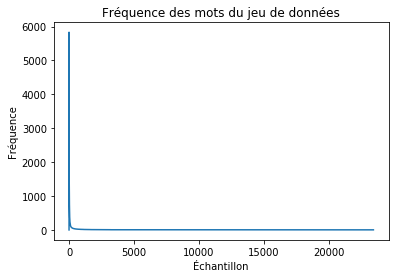

In [15]:
# si vocabulary_size est plus grand que le nombre de mots disponibles, on le change
data, count, dictionary, reverse_dictionary, args = step_2(words, verbose)
del(words) # mémoire

In [16]:
def step_3(data, index):
    print("Étape 3 : Fonction de test pour la génération d'un lot d'entraînement pour le modèle skip-gram")
    batch, labels, _ = generate_batch(data=data, index=index, batch_sz=8, n_skips=2, skip_sz=1)
    for i in range(8):
        print('\t', batch[i], reverse_dictionary[batch[i]], '->', labels[i], reverse_dictionary[labels[i]])
    
    return batch, labels

In [17]:
index = 0
batch, labels = step_3(data, index)

Étape 3 : Fonction de test pour la génération d'un lot d'entraînement pour le modèle skip-gram
	 171 Flaubert -> 139 Madame
	 171 Flaubert -> 546 Gustave
	 139 Madame -> 171 Flaubert
	 139 Madame -> 82 Bovary
	 82 Bovary -> 139 Madame
	 82 Bovary -> 9859 BeQ
	 9859 BeQ -> 82 Bovary
	 9859 BeQ -> 546 Gustave


In [18]:
def step_4(args, os, verbose):
    print("Étape 4 : Construction du modèle Skip Gram")
    net = SkipGram(args.vocabulary_size, args.embedding_size, verbose)
    
    # Load pretrained weights
    pretrained_file = './weights/w2v.model'
    if os.path.exists(pretrained_file):
        v_weights, u_weights = pickle.load(open(pretrained_file, 'r'))
        net.set_v_embeddings(v_weights)
        net.set_u_embeddings(u_weights)
    
    # Optimizer for parameters
    optimizer = torch.optim.SGD(net.parameters(), lr=args.learning_rate)

    # Cuda
    if args.cuda:
        net.cuda()

    # valid examples for checking
    valid_examples = np.random.choice(args.valid_window, args.valid_size, replace=False)
    batch_valid = torch.LongTensor(valid_examples)
    batch_valid = Variable(batch_valid.cuda()) if args.cuda else Variable(batch_valid)
    
    return net, optimizer, valid_examples, batch_valid

In [19]:
net, optimizer, valid_examples, batch_valid = step_4(args, os, verbose)
print(net)

Étape 4 : Construction du modèle Skip Gram
SkipGram(
  (v_embeddings): Embedding(23417, 2)
  (u_embeddings): Embedding(23417, 2)
)


In [20]:
def populate_arrays(origin, np_to_add):
    for index, item in enumerate(np.nditer(np_to_add)):
        origin.append(item)
    return origin

In [21]:
def step_5(net, optimizer, args, data, index, verbose=0):
    print("Étape 5 : Entraînement du modèle Skip Gram")
    avg_loss = 0
    losses, inps, tgts, negs = [], [], [], []

    for step in range(args.num_steps):
        batch_mids, batch_lbls, index = generate_batch(data, index, args.batch_size, args.num_skips, args.skip_window)

        # batch_inps: 1d array: (batch_size)
        batch_inps = np.squeeze(batch_mids)

        # batch_tgts: 1d array: (batch_size)
        batch_tgts = np.squeeze(batch_lbls)

        # batch_negs: 2d array: (batch_size, num_neg) in this case, we use other pos_v as neg_v
        batch_negs = np.repeat(np.expand_dims(batch_lbls, 1).transpose(), batch_lbls.shape[0], axis=0)
        # batch_negs = np.tile(np.repeat(np.expand_dims(batch_lbls, 1).transpose(), batch_lbls.shape[0], axis=0), 2)

        if verbose:
            print('batch_inps:', batch_inps.shape)
            print(batch_inps)
            print('batch_tgts:', batch_tgts.shape)
            print(batch_tgts)
            print('batch_negs:', batch_negs.shape)
            print(batch_negs)

        # To long tensor
        batch_inps = torch.LongTensor(batch_inps)
        batch_tgts = torch.LongTensor(batch_tgts)
        batch_negs = torch.LongTensor(batch_negs)

        # Cuda
        batch_inps = Variable(batch_inps.cuda()) if args.cuda else Variable(batch_inps)
        batch_tgts = Variable(batch_tgts.cuda()) if args.cuda else Variable(batch_tgts)
        batch_negs = Variable(batch_negs.cuda()) if args.cuda else Variable(batch_negs)
        
        # history
        inps = populate_arrays(inps, batch_inps.numpy())
        tgts = populate_arrays(tgts, batch_tgts.numpy())
        negs = populate_arrays(negs, batch_negs.numpy())

        # Zero gradient
        net.zero_grad()

        # Forward and get loss
        loss = net(batch_inps, batch_tgts, batch_negs)

        # Backward
        loss.backward()

        # Step the optimizer
        optimizer.step()

        avg_loss += loss.item() # data[0]
        losses.append(avg_loss)
        
        if step % args.avg_step == 0:
            if step > 0:
                avg_loss /= args.avg_step
            print('\tAverage loss at iteration %6d:' % step, avg_loss)
            avg_loss = 0

        if step % args.ckpt_step == 0:
            # Get embeddings of valid words and perform L2-normalization
            valid_embeddings = net.forward_v(batch_valid)
            valid_embeddings = valid_embeddings.data.cpu().numpy() if args.cuda else valid_embeddings.data.numpy()
            valid_embeddings = normalize(valid_embeddings, norm='l2', axis=1)

            # Get embeddings of all words and perform L2-normalization
            embeddings = net.get_v_embeddings().cpu().numpy() if args.cuda else net.get_v_embeddings().numpy()
            normalized_embeddings = normalize(embeddings, norm='l2', axis=1)

            # Compute cosine similarity between valid words and all words in dictionary
            sim = np.matmul(valid_embeddings, np.transpose(normalized_embeddings))

            # Print top-k neighbors for each valid word
            for i in range(args.valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]

                log_str = '\tNearest to %-10s :' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %-16s' % (log_str, close_word)

        
    # graph   
    fig, ax = plt.subplots(1, 4)
    fig.set_figwidth(15)
    ax[0].set_title('Inps')
    ax[0].hist(inps)
    del(inps) # mémoire
    ax[0].set_xlabel('xlabel')
    ax[0].set_ylabel('ylabel')
    
    ax[1].set_title('tgts')
    ax[1].hist(tgts)
    del(tgts) # mémoire
    
    ax[2].set_title('negs')
    ax[2].hist(negs)
    del(negs) # mémoire
    
    ax[3].set_title('Average loss')
    ax[3].plot(losses)
    del(losses) # mémoire
    ax[3].set_xlabel('Itération')
    ax[3].set_ylabel('losse')
    

Étape 5 : Entraînement du modèle Skip Gram
	Average loss at iteration      0: 1.47862708568573
	Average loss at iteration   2000: 1.4761023506820201
	Average loss at iteration   4000: 1.4308285202980042
	Average loss at iteration   6000: 1.4210139334201812
	Average loss at iteration   8000: 1.4178844658136367
	Average loss at iteration  10000: 1.4139342129826546
	Average loss at iteration  12000: 1.3816849040687085
	Average loss at iteration  14000: 1.3891785196065902
	Average loss at iteration  16000: 1.3743350754380226
	Average loss at iteration  18000: 1.3759834688603878
	Average loss at iteration  20000: 1.3743956590890885
	Average loss at iteration  22000: 1.3632224677503109
	Average loss at iteration  24000: 1.3739475105702876
	Average loss at iteration  26000: 1.3692114048004151
	Average loss at iteration  28000: 1.3469339220523835
	Average loss at iteration  30000: 1.345007154762745
	Average loss at iteration  32000: 1.3557442852258683
	Average loss at iteration  34000: 1.34547

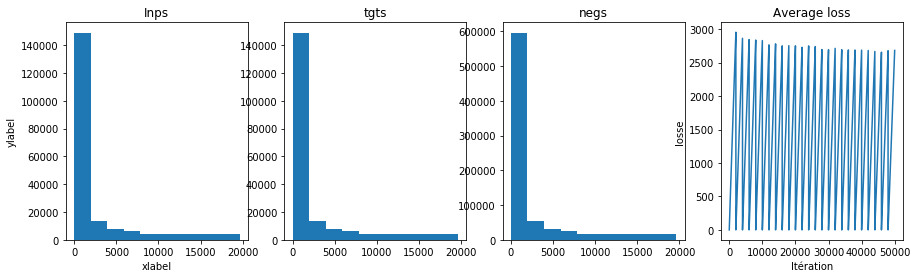

In [22]:
step_5(net, optimizer, args, data, index, 0)

In [23]:
def step_6(net, args, os):
    print("Étape 6 : Enregistrement du modèle formé")
    embeddings = net.get_v_embeddings().cpu().numpy() if args.cuda else net.get_v_embeddings().numpy()
    final_embeddings = normalize(embeddings, norm='l2', axis=1)

    model_dir = './models'
    maybe_create_path(model_dir)
    model_path = os.path.join(model_dir, 'word2vec_pt.model')

    print('\tSaving trained weights to %s' % model_path)
    pickle.dump([final_embeddings, dictionary, reverse_dictionary], open(model_path, 'wb'))

In [24]:
step_6(net, args, os)

Étape 6 : Enregistrement du modèle formé
	Saving trained weights to ./models/word2vec_pt.model
